In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [2]:
import torchaudio
audio, sr = torchaudio.load('/content/120_Cm_Piano_481.wav')
audio[0].type()

'torch.FloatTensor'

In [3]:
audio=audio[0]

In [4]:
length=audio.shape[0]/sr
print(f"Audio Length:{length} seconds")

Audio Length:16.0 seconds


Clipping 5 seconds of the audio

In [5]:
audio=audio[4*sr:9*sr]

In [6]:
from IPython.display import Audio
Audio(audio,rate=sr)

In [7]:
def audio_plot(audio, sr, clr, tl):
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

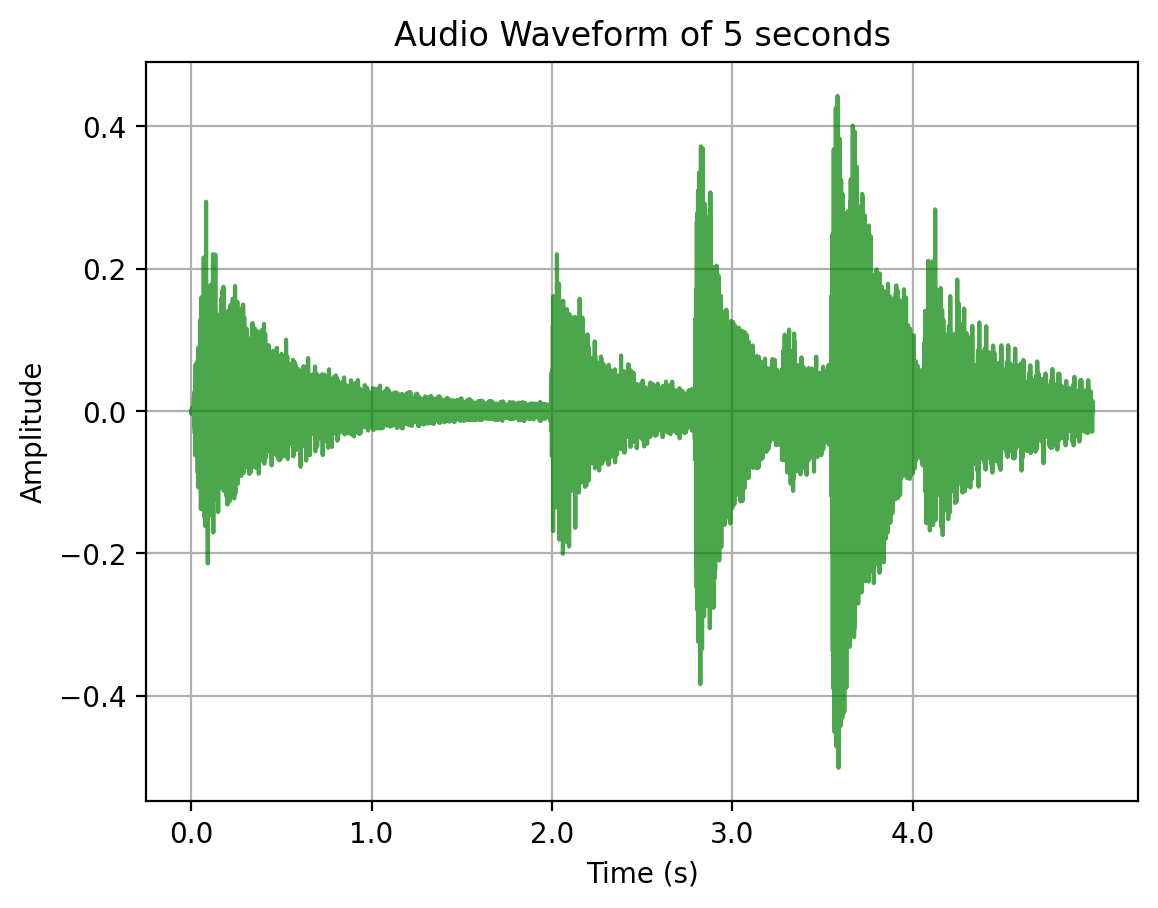

In [21]:
audio_plot(audio, sr, 'green', 'Audio Waveform of 5 seconds')

Creating Time Series Domain

In [9]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


# Creating RFF

In [10]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [22]:
num_features = 25000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 25000])
tensor([[-0.0036, -0.0089, -0.0088,  ...,  0.0045,  0.0035,  0.0088],
        [-0.0029, -0.0089, -0.0088,  ...,  0.0044,  0.0029,  0.0087],
        [-0.0022, -0.0089, -0.0088,  ...,  0.0043,  0.0022,  0.0087],
        ...,
        [ 0.0043, -0.0072, -0.0087,  ...,  0.0059, -0.0035, -0.0023],
        [ 0.0036, -0.0068, -0.0087,  ...,  0.0059, -0.0028, -0.0023],
        [ 0.0030, -0.0062, -0.0087,  ...,  0.0058, -0.0021, -0.0024]])


# Fitting a Linear Model over Expanded Domain

In [23]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [24]:
#Reconstructed Audio
Audio(pred_audio, rate = sr)

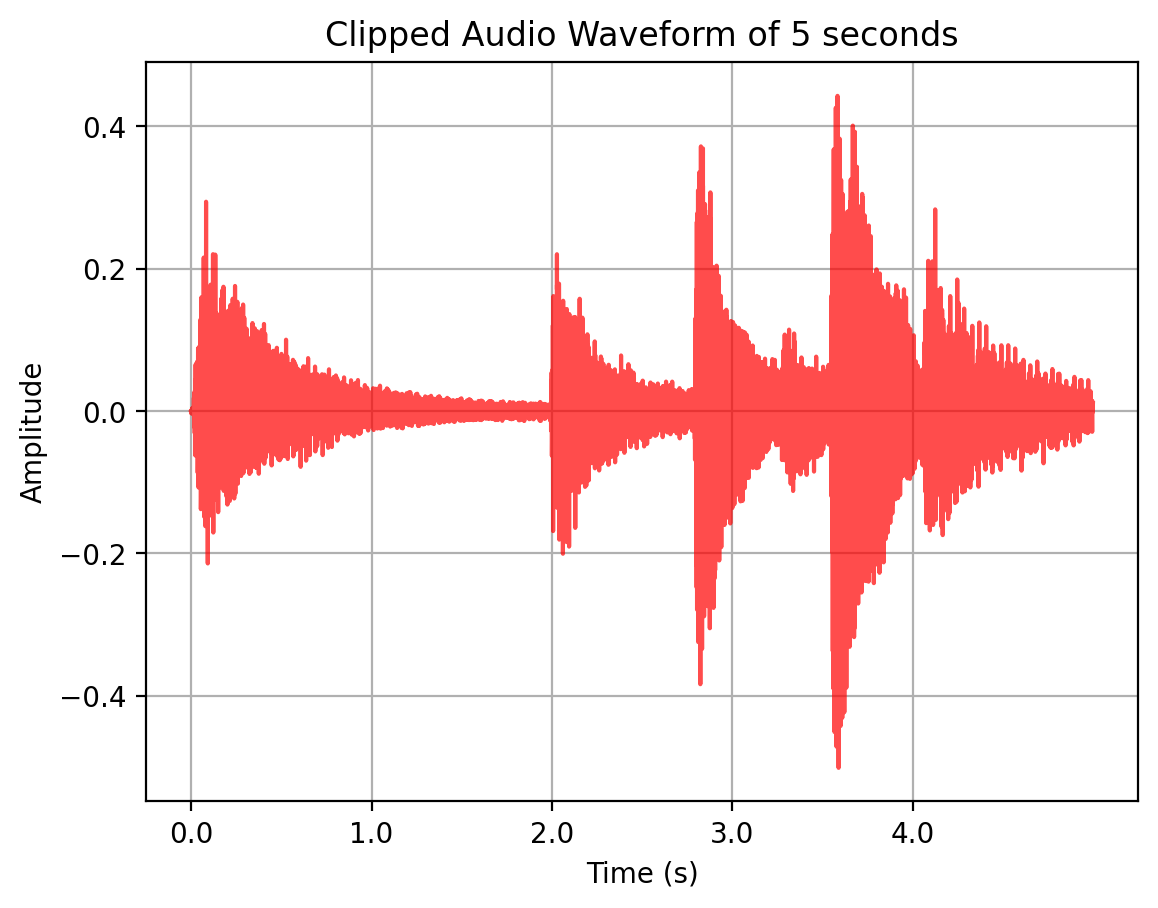

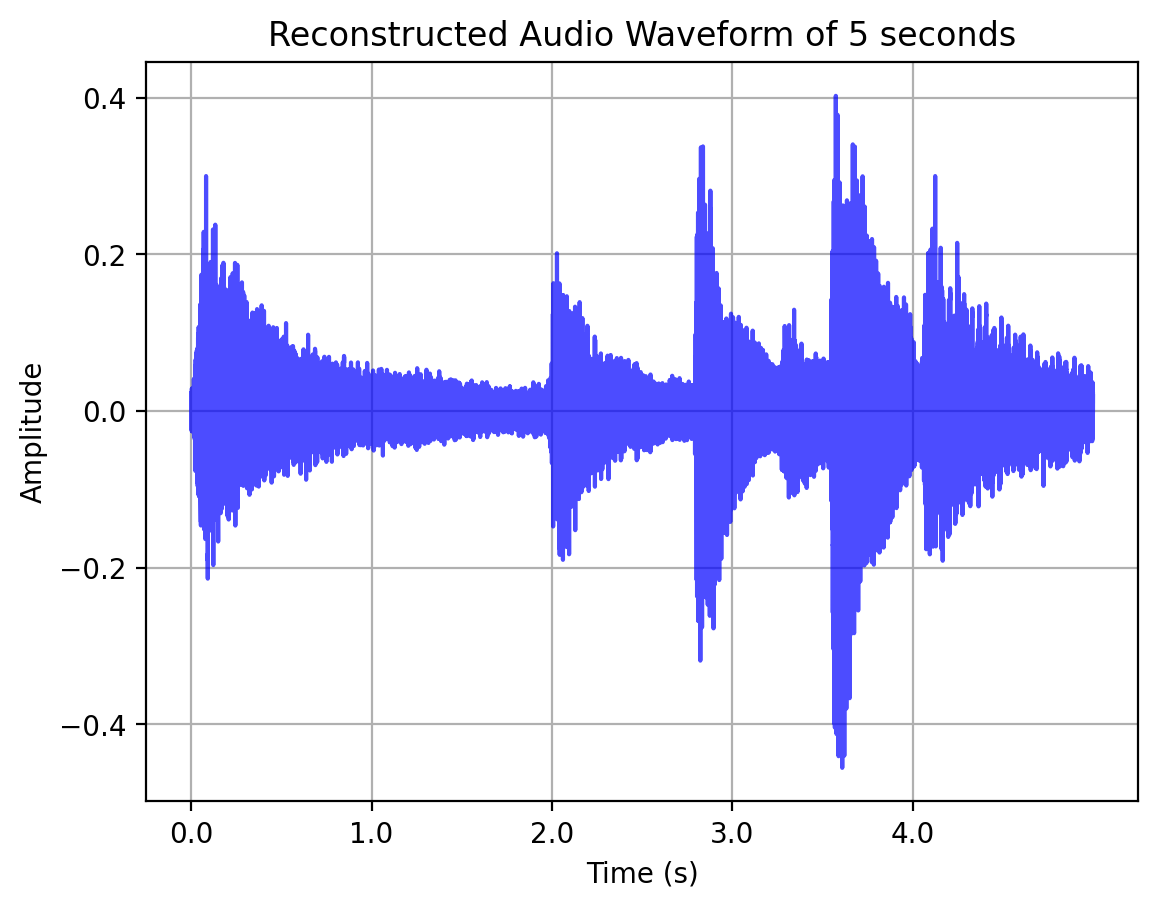

In [25]:
audio_plot(audio, sr, 'red', 'Clipped Audio Waveform of 5 seconds')
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform of 5 seconds')

In [26]:
def mse(predicted, original):
    """Calculates the Mean Squared Error between two tensors."""
    return torch.mean((predicted - original) ** 2)

def signal_power(original):
    """Calculates the power of the original signal."""
    return torch.mean(original ** 2)

def noise_power(predicted, original):
    """Calculates the power of the noise."""
    return mse(predicted, original)

def snr(predicted, original):
    """Calculates the Signal-to-Noise Ratio."""
    signal_power_db = 10 * torch.log10(signal_power(original))
    noise_power_db = 10 * torch.log10(noise_power(predicted, original))
    return signal_power_db - noise_power_db

In [27]:
snr_ans=snr(torch.from_numpy(pred_audio),audio)
print(f"SNR:",snr_ans.item())

SNR: 10.175418853759766
